In [1]:
import scanpy as sc

In [30]:
adata_l2_1 = sc.read("/home/icb/dominik.klein/data/genot/pancreas_l2_cost.h5ad")
adata_l2_2 = sc.read("/home/icb/dominik.klein/data/genot/pancreas_l2_cost_2.h5ad")
adata_l2_3 = sc.read("/home/icb/dominik.klein/data/genot/pancreas_l2_cost_3.h5ad")

In [31]:
adata_geo_1 = sc.read("/home/icb/dominik.klein/data/genot/pancreas_geodesic_cost.h5ad")
adata_geo_2 = sc.read("/home/icb/dominik.klein/data/genot/pancreas_geodesic_cost_2.h5ad")
adata_geo_3 = sc.read("/home/icb/dominik.klein/data/genot/pancreas_geodesic_cost_3.h5ad")

In [32]:
preds_l2_1 = adata_l2_1.obsm["velocities"] + adata_l2_1.obsm["X_pca"] 
preds_l2_2 = adata_l2_2.obsm["velocities"] + adata_l2_2.obsm["X_pca"] 
preds_l2_3 = adata_l2_3.obsm["velocities"] + adata_l2_3.obsm["X_pca"] 

In [33]:
preds_geo_1 = adata_geo_1.obsm["velocities"] + adata_geo_1.obsm["X_pca"] 
preds_geo_2 = adata_geo_2.obsm["velocities"] + adata_geo_2.obsm["X_pca"] 
preds_geo_3 = adata_geo_3.obsm["velocities"] + adata_geo_3.obsm["X_pca"] 

In [4]:
from typing import Tuple, Callable, Union, List, Optional
import scipy.sparse as sp
import jax.numpy as jnp
import jax
import pandas as pd

def get_nearest_neighbors(
    input_batch: jnp.ndarray, target: jnp.ndarray, k: int = 30
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """Get the k nearest neighbors of the input batch in the target."""
    if target.shape[0] < k:
        raise ValueError(f"k is {k}, but must be smaller or equal than {target.shape[0]}.")
    pairwise_euclidean_distances = jnp.sqrt(jnp.sum((input_batch - target) ** 2, axis=-1))
    negative_distances, indices = jax.lax.top_k(-1 * pairwise_euclidean_distances, k=k)
    return -1 * negative_distances, indices

def project_transport_matrix(  
        predicted_tgt_cells: jnp.ndarray,
        tgt_cells: jnp.ndarray,
        batch_size: int = 1024,
        k: int = 1,
    ) -> sp.csr_matrix:
        """Project Neural OT map onto cells."""

        get_knn_fn = jax.vmap(get_nearest_neighbors, in_axes=(0, None, None))
        row_indices: Union[jnp.ndarray, List[jnp.ndarray]] = []
        column_indices: Union[jnp.ndarray, List[jnp.ndarray]] = []
        distances_list: Union[jnp.ndarray, List[jnp.ndarray]] = []
        for index in range(0, len(predicted_tgt_cells), batch_size):
            _, indices = get_knn_fn(predicted_tgt_cells[index : index + batch_size], tgt_cells, k)
            column_indices.append(indices.flatten())
            row_indices.append(
                jnp.repeat(jnp.arange(index, index + min(batch_size, len(predicted_tgt_cells) - index)), min(k, len(tgt_cells)))
            )
        ri = jnp.concatenate(row_indices)
        ci = jnp.concatenate(column_indices)
        mat = np.zeros((len(ri), len(tgt_cells)))
        mat[ri,ci] = 1.0
        return mat

def aggregate_transport_matrix(adata_source, adata_target, tmat, aggregation_key = "celltype", forward = True):
    df_source = adata_source.obs[aggregation_key]
    df_target = adata_target.obs[aggregation_key]

    annotations_source = adata_source.obs[aggregation_key].cat.categories
    annotations_target = adata_target.obs[aggregation_key].cat.categories

    tm = pd.DataFrame(
        np.zeros((len(annotations_source), len(annotations_target))),
        index=annotations_source,
        columns=annotations_target,
    )
    
    for annotation_src in annotations_source:
        for annotation_tgt in annotations_target:
            tm.loc[annotation_src, annotation_tgt] = tmat[
                np.ix_((df_source == annotation_src).squeeze(), (df_target == annotation_tgt).squeeze())
            ].sum()
    return tm.div(tm.sum(axis=int(forward)), axis=int(not forward))

In [34]:
adatas = [adata_l2_1, adata_l2_2, adata_l2_3, adata_geo_1, adata_geo_2, adata_geo_3]
preds = [preds_l2_1, preds_l2_2, preds_l2_3, preds_geo_1, preds_geo_2, preds_geo_3]
agg_tms = [None] * 6

In [36]:
for i, (adata, pred) in enumerate(zip(adatas, preds)):
    source = adata[adata.obs["day"]=="14.5"].obsm["X_pca"]
    target = adata[adata.obs["day"]=="15.5"].obsm["X_pca"]
    tm = project_transport_matrix(pred[adata.obs["day"]=="14.5"], target)
    adata_source = adata[adata.obs["day"]=="14.5"]
    adata_target = adata[adata.obs["day"]=="15.5"]
    agg_tms[i] = aggregate_transport_matrix(adata_source, adata_target, tm, forward=False)

In [58]:
tms_red = [None] * 6
for i, tm in enumerate(agg_tms):
    tm_red = tm[["Alpha", "Beta", "Delta", "Epsilon"]].loc[["Ngn3 low EP", "Ngn3 High late"]].T
    tm_red["cost"] = "geo" if i>2 else "l2"
    tms_red[i] = tm_red

In [59]:
df_concat = pd.concat(tms_red)

In [60]:
df_concat = df_concat.fillna(0)

In [61]:
df_concat

,Ngn3 low EP,Ngn3 High late,cost
Alpha,0.117574,0.003713,l2
Beta,0.189071,0.020765,l2
Delta,0.438776,0.040816,l2
Epsilon,0.230189,0.113208,l2
Alpha,0.140845,0.006402,l2
Beta,0.171039,0.030430,l2
Delta,0.300000,0.037500,l2
Epsilon,0.231405,0.099174,l2
Alpha,0.115942,0.007905,l2
Beta,0.208167,0.023904,l2


<Axes: xlabel='None', ylabel='Ngn3 low EP'>

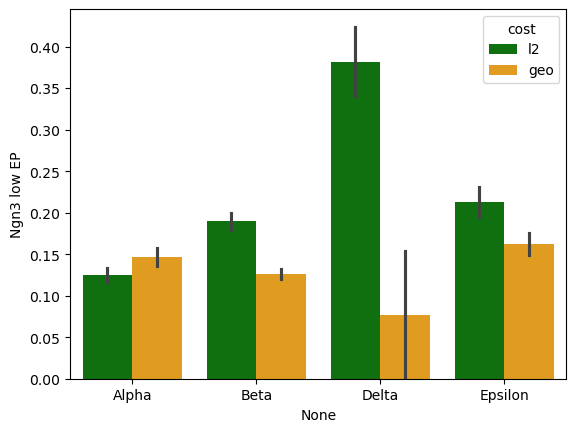

In [66]:
sns.barplot(df_concat, x=df_concat.index, y="Ngn3 low EP", hue="cost", palette=["green", "orange"], errorbar="se")

<Axes: xlabel='None', ylabel='Ngn3 High late'>

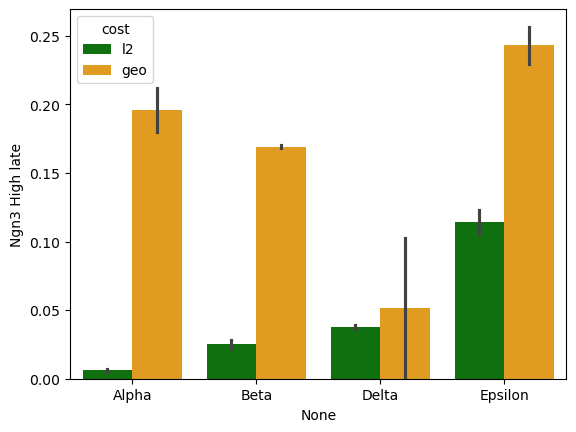

In [67]:
sns.barplot(df_concat, x=df_concat.index, y="Ngn3 High late", hue="cost", palette=["green", "orange"], errorbar="se")

In [68]:
df_concat.groupby("cost").mean()

,Ngn3 low EP,Ngn3 High late
cost,,
geo,0.128088,0.164857
l2,0.227168,0.045737


In [69]:
df_concat.groupby("cost").std()

,Ngn3 low EP,Ngn3 High late
cost,,
geo,0.067418,0.084425
l2,0.105270,0.043405


In [70]:
df_concat.groupby("cost").var()

,Ngn3 low EP,Ngn3 High late
cost,,
geo,0.004545,0.007128
l2,0.011082,0.001884
